In [1]:
# импортируем библиотеки для работы с данными
import pandas as pd
from sklearn import preprocessing 

# загрузим данные
df = pd.read_csv("segmented_customers.csv")
# посмотрим на данные
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,1,19.0,15.0,39.0
1,2,1,21.0,15.0,81.0
2,3,0,20.0,16.0,6.0
3,4,0,23.0,16.0,77.0
4,5,0,31.0,17.0,40.0


Проведём предобработку данных: удалим пропуски и дубли, признак Gender превратим в бинарный с помощью LabelEncoder:

In [4]:
# посмотрим, есть ли пропуски в датасете
df[df.isna().any(axis=1)]

,customer_id,gender,age,annual_income,spending_score


In [5]:
# пропусков не так много, поэтому мы можем удалить данные с пропусками
df = df.dropna()

# переименуем столбцы для более удобной работы
df.rename(columns = {'CustomerID' : 'customer_id', 'Gender' : 'gender', 
                    'Age': 'age', 'Annual Income (k$)': 'annual_income', 
                    'Spending Score (1-100)': 'spending_score', }, inplace = True)

In [6]:
# проверим, есть ли в данных дубликаты
df[df.duplicated(subset=['customer_id'])]

,customer_id,gender,age,annual_income,spending_score


Чтобы мы могли визуально оценивать результаты кластеризации, будем проводить её по трём признакам, а именно: годовой заработок, коэффициент покупательской способности и возраст. Визуализируем распределение данных:

In [7]:
import plotly
import plotly.express as px

# передаём датафрейм и поля, которые нужно использовать для осей абсцисс, ординат и аппликат
fig = px.scatter_3d(
    data_frame=df, 
    x = 'age', 
    y = 'annual_income', 
    z = 'spending_score', 
    width=1000,
    height=700
)

#отображаем график
fig.show()

Так как нам часто будет требоваться визуализировать результаты кластеризации, напишем для этого функцию. Она будет принимать датафрейм и название столбца датафрейма с результатами кластеризации. Так как нас будут стабильно интересовать три столбца (age, annual_income, spending_score), зафиксируем их названия внутри функции:

In [8]:
def get_3d_visualization(df, clust_res):
    fig = px.scatter_3d(
        data_frame=df, 
        x = 'age', 
        y = 'annual_income', 
        z = 'spending_score', 
        color = clust_res,
        width=1000,
        height=700
    )

    #возвращаем график
    return fig

Сохраним признаки, по которым будем проводить моделирование, в переменную X:

In [9]:
X = df[['age', 'annual_income', 'spending_score']]

In [ ]:
#Задание 10.1
#Попробуйте провести DBSCAN-кластеризацию со значениями по умолчанию. Сколько кластеров у вас получилось?

In [11]:
from sklearn.cluster import DBSCAN

In [12]:
clustering = DBSCAN(eps=0.7, min_samples=5).fit(X)
#clustering.labels_
get_3d_visualization(X, clustering.labels_)


In [13]:
dbscan = DBSCAN(eps=11)
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_11'] = clustering_dbscan_res

get_3d_visualization(df, 'dbscan_res_eps_11')

Проведём агломеративную кластеризацию, чтобы построить дендрограмму и по ней оценить количество кластеров, на которое можно разделить датасет. Напишем функцию, которая будет принимать количество кластеров и матрицу с признаками:

In [14]:
# импортируем алгомеративную кластеризацию из sklearn
from sklearn.cluster import AgglomerativeClustering

# напишем функцию, которая будет проводить алгомеративную кластеризацию
# на вход она будет принимать X — матрицу с признаками для кластеризации и n_clusters — количество кластеров,
# на выходе будет возвращать список с номерами кластеров
def get_aggl_clustering(X, n_clusters):
    # запустим агломеративную кластеризацию
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    # обучим модель агломеративной кластеризации
    agglomerative_clustering.fit(X)
    # получим список c информацией, к какому кластеру относятся объекты
    aggl_prediction = agglomerative_clustering.labels_
    # вернём список с результатами
    return aggl_prediction

Теперь, вооружившись знаниями из юнита про иерархическую кластеризацию, самостоятельно проведите агломеративную кластеризацию, воспользовавшись функцией, которую мы только что написали. После этого визуализируйте полученную дендрограмму. Количество кластеров для кластеризации укажите равным 3 (на данном этапе это не очень важно).

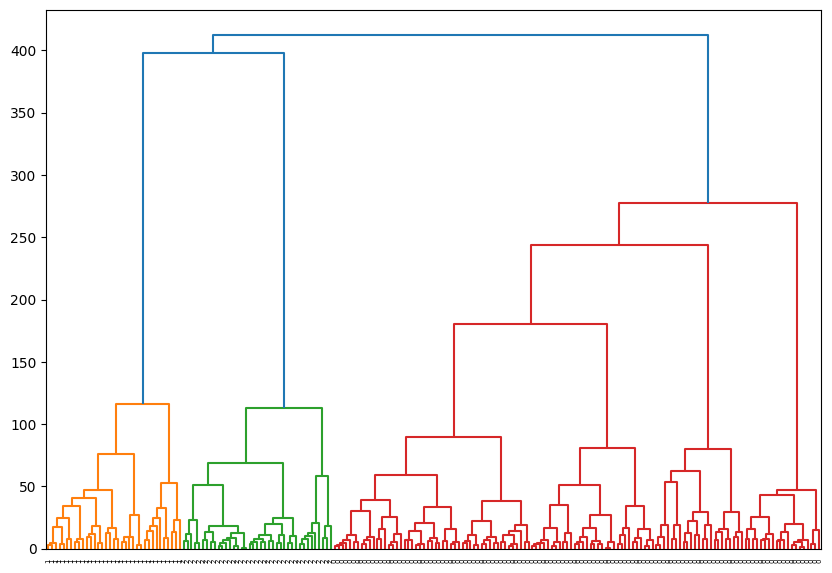

In [19]:
prediction = get_aggl_clustering(X, 3)

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

# рассчитаем расстояния между кластерами
linked = linkage(X, 'ward')
plt.figure(figsize=(10, 7))

# визуализируем дендрограмму с ориентацией top
# сначала будут отрисовываться кластеры с минимальным расстоянием между ними
dendrogram(Z=linked,
            orientation='top',
            labels=prediction,
            distance_sort='descending')

plt.show()


In [20]:
df['aggl_res_6'] = get_aggl_clustering(df[['age', 'annual_income', 'spending_score']], 6)
get_3d_visualization(df, 'aggl_res_6')

In [ ]:
#Задание 10.4
#Для агломеративной кластеризации самостоятельно с помощью коэффициента силуэта подберите оптимальное количество кластеров. 
#Сколько кластеров у вас получилось?

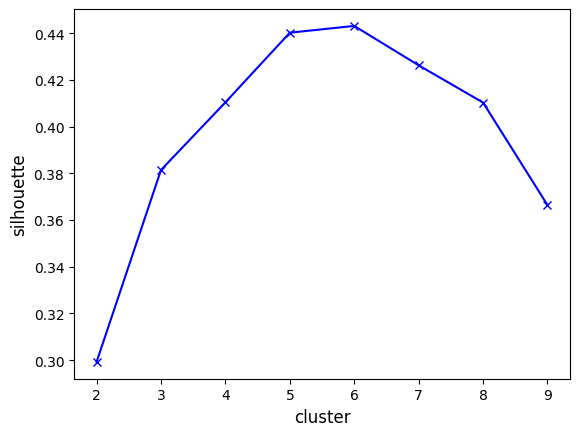

In [22]:
# импортируем метрику силуэта
from sklearn.metrics import silhouette_score

# напишем функцию, как и при подсчёте метода локтя
def get_silhouette(cluster_num, X):
    pred =  get_aggl_clustering(df[['age', 'annual_income', 'spending_score']], cluster_num)
    silhouette = silhouette_score(X, pred)
    return silhouette

silhouette = []
for clust_num in range(2, 10):
    silhouette.append(get_silhouette(clust_num, X))

# визуализируем коэффициенты силуэта для разного количества кластеров
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(2, 10)], silhouette, 'xb-')